In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import reverse_geocoder as rg 
import pprint 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, OneHotEncoder)
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

# Utilities

In [16]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
    
    return result[0]['admin1'], result[0]['name']

# Dataframe must have been given reset_indexed
# Complete missing values where deparment and municipality are unknown
def relocate(df_geo):
    n = df_geo.shape[0]
    for i in tqdm(range(0,n)):
        lat = df_geo.loc[i, 'lat']
        lon = df_geo.loc[i, 'lon']
        l2 = df_geo.loc[i, 'l2']
        l3 = df_geo.loc[i, 'l3']
        if (~np.isnan(lat) and ~np.isnan(lon)) and (pd.isnull(l3) or pd.isnull(l2)):
            df_geo.loc[i, 'l2'], df_geo.loc[i, 'l3'] = reverseGeocode((lat,lon))
            
    return df_geo

#Calculates missing data and shows dataframe
def calculate_missing(df):
    s_types = df.dtypes
    missing = df.isnull().sum()
    missing_per = (df.isnull().sum()/df.shape[0])*100

    explo = pd.DataFrame({'Type' : s_types, 'Missing' : missing,
                       'Missing%' : missing_per}).sort_values(by=['Missing%', 'Type'], ascending=False)

    return explo

#Graph missing data given dataframe
def graph_missing(df):

    df_missing = calculate_missing(df)

    df_missing = df_missing.where(df_missing['Missing%'] > 25).dropna(subset=['Missing%'])

    sns.barplot(x=df_missing.index, y=df_missing['Missing%'], data=df_missing)

## Processing

In [17]:
df = pd.read_csv('properties_co.csv')

In [18]:
df = df.where(df['price'] > 0).dropna(subset=['price'])

df.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                123483
lon                123483
l1                      0
l2                      0
l3                      0
l4                 653425
l5                 795847
l6                 892800
rooms              558509
bedrooms           498812
bathrooms          120747
surface_total      339878
surface_covered    517718
price                   0
currency                0
price_period       680665
title                   0
description            18
property_type           1
operation_type          1
dtype: int64

In [19]:
df = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df.drop(columns=['operation_type', 'l6', 'l5', 'l4', 'l3', 'l1', 'rooms', 'price_period', 'surface_covered', 'id', 'start_date', 'Unnamed: 0', 'title', 'description',  'start_date', 'end_date', 'created_on', 'ad_type'], inplace=True)

In [20]:
def cop_to_usd(currency, price):
    if currency == 'USD':
        return price*3200
    return price

In [21]:
df['price'] = tqdm(df.apply(lambda x: cop_to_usd(x.currency, x.price), axis=1))

100%|██████████| 603276/603276 [00:00<00:00, 3034178.65it/s]


In [22]:
df.isnull().sum()

lat               80982
lon               80982
l2                    0
bedrooms         342494
bathrooms         86886
surface_total    229033
price                 0
currency              0
property_type         0
dtype: int64

In [23]:
df.drop(columns=['currency'], inplace = True)

In [24]:
housing_data = df.copy()
housing_data['price'] = np.log(housing_data['price'])
housing_data['price_per_m2'] = housing_data['price']/housing_data['surface_total']

In [25]:
housing_data.rename(columns={'l2' : 'deparment'}, inplace = True)

In [26]:
housing_data.isnull().sum()

lat               80982
lon               80982
deparment             0
bedrooms         342494
bathrooms         86886
surface_total    229033
price                 0
property_type         0
price_per_m2     229033
dtype: int64

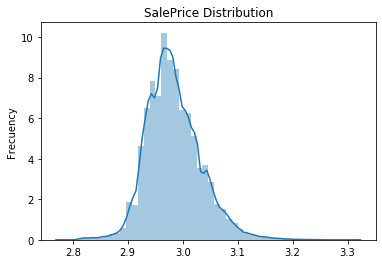

In [27]:
ax = sns.distplot(np.log(housing_data['price']));
ax.set(xlabel='', ylabel='Frecuency',title ="SalePrice Distribution")
plt.show()

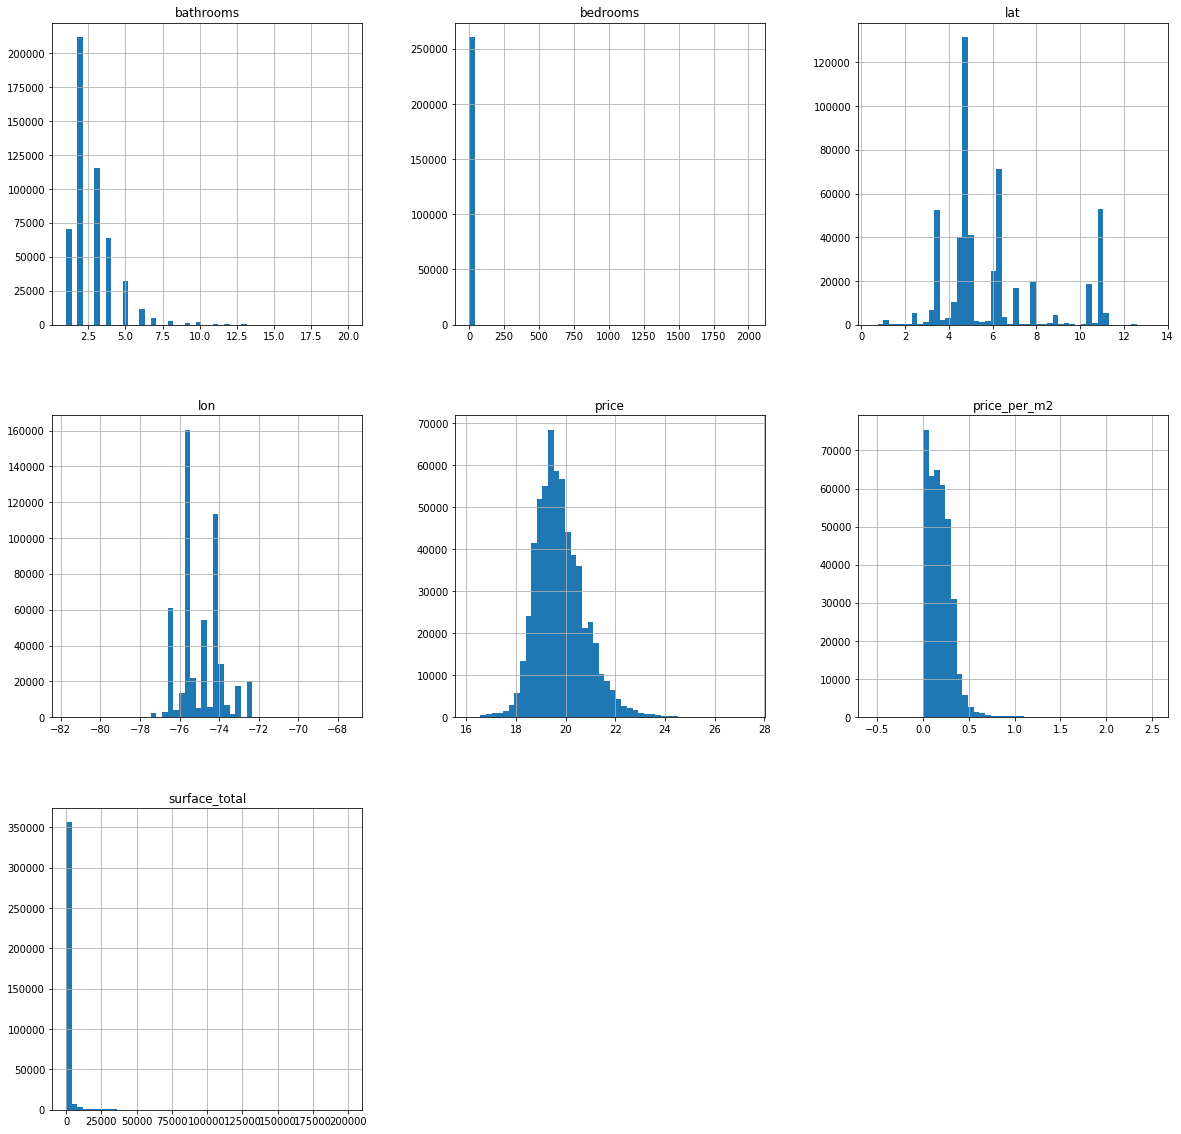

In [28]:
housing_data.hist(bins=50, figsize=(20,20))
plt.show()

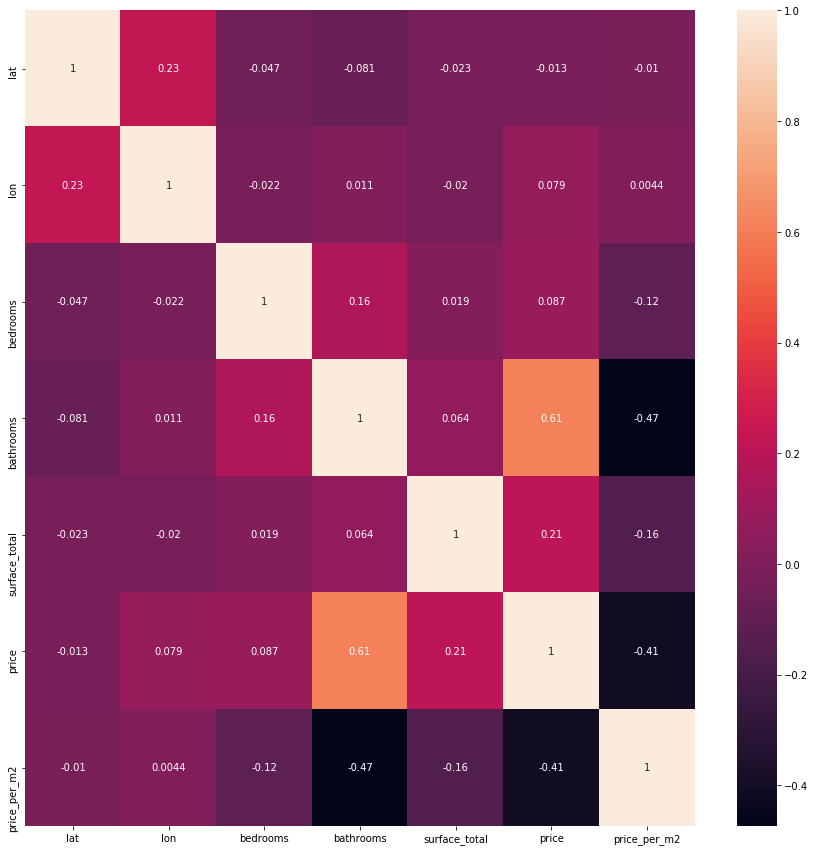

In [29]:
corr = housing_data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

In [30]:
housing_data.columns

Index(['lat', 'lon', 'deparment', 'bedrooms', 'bathrooms', 'surface_total',
       'price', 'property_type', 'price_per_m2'],
      dtype='object')

In [31]:
housing_data = housing_data.drop(housing_data.index[153283])
housing_data[housing_data['surface_total']<=0]

,lat,lon,deparment,bedrooms,bathrooms,surface_total,price,property_type,price_per_m2


In [33]:
deparments = list(housing_data['deparment'].value_counts().index)[0:30]
housing_data = housing_data[housing_data['deparment'].isin(deparments)]

In [34]:
housing_data

,lat,lon,deparment,bedrooms,bathrooms,surface_total,price,property_type,price_per_m2
0,3.439000,-76.541000,Valle del Cauca,12.0,6.0,202.0,20.030119,Casa,0.099159
2,3.566000,-76.550000,Valle del Cauca,6.0,2.0,2500.0,18.757153,Casa,0.007503
3,4.736000,-75.896000,Valle del Cauca,8.0,5.0,45000.0,20.500122,Casa,0.000456
4,3.661000,-76.576000,Valle del Cauca,6.0,6.0,650.0,19.485391,Casa,0.029978
11,2.472816,-76.574428,Cauca,NaN,3.0,125.0,19.062535,Casa,0.152500
...,...,...,...,...,...,...,...,...,...
937780,7.869000,-72.465000,Norte de Santander,5.0,7.0,1000.0,21.976029,Casa,0.021976
937781,7.873000,-72.464000,Norte de Santander,5.0,7.0,1262.0,21.128731,Casa,0.016742
937782,7.844000,-72.467000,Norte de Santander,5.0,7.0,344.0,20.818576,Casa,0.060519
937783,7.855000,-72.464000,Norte de Santander,7.0,7.0,500.0,20.560747,Casa,0.041121


## Machine Learning

In [35]:
X_df = housing_data.drop('price', axis=1).copy()
Y_df = housing_data['price'].copy()

In [36]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(X_df, Y_df, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [37]:
X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [38]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

In [39]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,deparment,bedrooms,bathrooms,surface_total,property_type,price_per_m2
758572,NaN,NaN,Magdalena,NaN,3.0,NaN,Apartamento,NaN
814619,3.491000,-76.515000,Valle del Cauca,NaN,2.0,NaN,Otro,NaN
343705,5.055481,-75.485059,Caldas,NaN,NaN,-0.960322,Otro,0.327891
218728,4.721850,-74.067098,Cundinamarca,NaN,3.0,NaN,Apartamento,NaN
420470,NaN,NaN,Antioquia,3.0,2.0,-0.450132,Otro,0.225390


In [40]:
box_cox.lambdas_

array([-0.40408571])

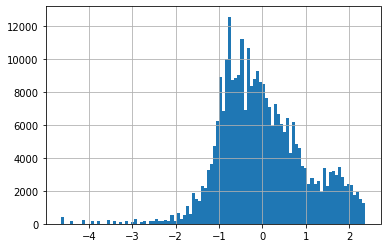

In [41]:
X_train["surface_total"].hist(bins=100)
plt.show()

In [42]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

le_deparment = LabelEncoder()
le_deparment.fit(X_train['deparment'])
X_train['deparment'] = le_deparment.transform(X_train['deparment'])


ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array_proper = out.toarray()
ohe_cols_proper_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_proper_op.append(col_add)
    X_train[col_add] = out_array_proper[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

ohe_deparment = OneHotEncoder()
ohe_deparment.fit(X_train["deparment"].values[:,None])
out = ohe_deparment.transform(X_train["deparment"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_deparment.categories_[0]:
    current_class = le_deparment.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("deparment", axis =1)

In [43]:
ohe_deparment.categories_[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [44]:
from sklearn.impute import SimpleImputer
# NaNs Columns
X_test['deparment'].value_counts()



Cundinamarca                               33181
Antioquia                                  24395
Valle del Cauca                            14373
Atlántico                                  11659
Caldas                                      6975
Quindío                                     4359
Norte de Santander                          4230
Bolívar                                     4200
Risaralda                                   4173
Santander                                   4058
Tolima                                      1585
Meta                                        1339
Magdalena                                   1248
Cauca                                       1183
Cordoba                                      989
Quindio                                      683
Narino                                       366
Huila                                        366
Boyacá                                       327
Casanare                                     203
Tachira             

In [45]:
si_bedrooms = SimpleImputer(strategy='median')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='median')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='median')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='median')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

si_price_per_m2 = SimpleImputer(strategy='median')
si_price_per_m2.fit(X_train["price_per_m2"].values[:,None])
X_train["price_per_m2"] = si_price_per_m2.transform(X_train["price_per_m2"].values[:,None])

si_surface_total = SimpleImputer(strategy='median')
si_surface_total.fit(X_train["surface_total"].values[:,None])
X_train["surface_total"] = si_surface_total.transform(X_train["surface_total"].values[:,None])

In [46]:
cols2scale = ['lon', 'lat', 'bedrooms', 'bathrooms', 'price_per_m2']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_per_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,...,op_Norte de Santander,op_Quindio,op_Quindío,op_Risaralda,op_San Andrés Providencia y Santa Catalina,op_Santander,op_Sucre,op_Tachira,op_Tolima,op_Valle del Cauca
758572,-0.410545,-0.291393,-0.039838,0.264159,-0.114116,-0.092496,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
814619,-1.050787,-1.531782,-0.039838,-0.461043,-0.114116,-0.092496,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
343705,-0.350317,-0.486344,-0.039838,-0.461043,-0.960322,1.107600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218728,-0.499694,0.952953,-0.039838,0.264159,-0.114116,-0.092496,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420470,-0.410545,-0.291393,-0.039838,-0.461043,-0.450132,0.347573,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


X_test['deparment'] = le_deparment.transform(X_test['deparment'])
temp_test = ohe_deparment.transform(X_test["deparment"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("deparment", axis=1)

In [48]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_proper_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)


In [49]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])
X_test['surface_total'] = si_surface_total.transform(X_test['surface_total'].values[:,None])
X_test['price_per_m2'] = si_price_per_m2.transform(X_test['price_per_m2'].values[:,None])

In [50]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [51]:
X_test = X_test[list(X_train.columns)]

In [52]:
assert (X_test.columns.values == X_train.columns.values).all()

In [53]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
lin_reg.intercept_, lin_reg.coef_

(19.773398782315496,
 array([ 0.00355331, -0.00652426, -0.00851316,  0.34728465,  0.72340397,
         0.27523377, -0.16360923, -0.27321383, -0.65912448, -0.22109026,
         0.31164028, -0.1138754 ,  0.32335063,  0.00150645,  0.79441584,
         0.19483055,  0.36115402,  0.21262573,  0.51897313,  0.19940024,
        -0.03533169, -0.06741846, -0.50404467, -0.16368752, -0.23570356,
        -0.24203982, -0.01542784, -0.2534068 ,  0.48755304,  0.09110127,
        -0.25530002,  0.23151764, -0.03800347, -0.02545243,  0.1036463 ,
        -0.1571099 , -0.14126626, -0.16040839, -0.14464989,  0.45578544,
        -0.06949991, -0.02357551, -0.21225954, -0.08238909, -0.02961261]))

In [54]:
Y_test_estimate = lin_reg.predict(X_test)

In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [56]:
rmse = mean_squared_error(Y_test, Y_test_estimate, squared=True)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))

Root Mean Square Error (RMSE)= 0.56


In [58]:
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))

Mean Absolute Error (MAE)= 0.51


In [59]:
r2 = r2_score(Y_test, Y_test_estimate)
print("R_2 = {:.3f}".format(r2))

R_2 = 0.423


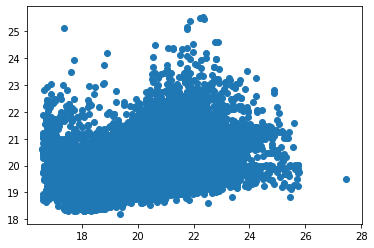

In [60]:
plt.scatter(Y_test, Y_test_estimate)

## Municipality

In [61]:
df = pd.read_csv('properties_co.csv')


In [ ]:
df = df[df['l3'].isin(list(df['l3'].value_counts().where(df['l3'].value_counts() > 200).dropna().index))]

In [ ]:
df = df.where(df['price'] > 0).dropna(subset=['price'])

In [ ]:
df = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df.drop(columns=['operation_type', 'l6', 'l5', 'l4', 'l2', 'l1', 'rooms', 'price_period', 'surface_covered', 'id', 'start_date', 'Unnamed: 0', 'title', 'description',  'start_date', 'end_date', 'created_on', 'ad_type'], inplace=True)

In [ ]:
def cop_to_usd(currency, price):
    if currency == 'USD':
        return price*3200
    return price

In [ ]:
df['price'] = tqdm(df.apply(lambda x: cop_to_usd(x.currency, x.price), axis=1))